In [265]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from scipy.linalg import eigvalsh 
import numpy as np

import matplotlib.pyplot as plt


torch.manual_seed(0)

torch.set_default_dtype(torch.float64)

# PGM - iterative
$$ s_{k+1} =  ReLU(s_{k} - n_{k} H^T(Hs_{k}-x)) $$

In [266]:
class SimulatedData(Data.Dataset): 
    def __init__(self, x, s): 
        self.x = x
        self.s = s

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        x = self.x[:, idx] 
        s = self.s[:, idx]
        return x, s


In [267]:
def create_data_set(H, x_size, s_size, N=1000, batch_size=32): 

        x = torch.zeros(x_size, N)        
        s = torch.zeros(s_size, N)
        
        for i in range(N):            
            s[:, i] = torch.abs(torch.randn(s_size))
            x[:, i] = H @ s[:, i]


        simulated = SimulatedData(x=x, s=s)
        data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
        return data_loader

# Data generation
ReLU module in pgm make sures that the sparse vector s is always non-negative

In [268]:
x_size, s_size = 150, 200
# Measurement matrix
H = torch.randn(x_size, s_size)
H /= torch.norm(H, dim=0) 

train_loader = create_data_set(H, x_size=x_size, s_size=s_size, N=800)
test_loader = create_data_set(H, x_size=x_size, s_size=s_size, N=200)

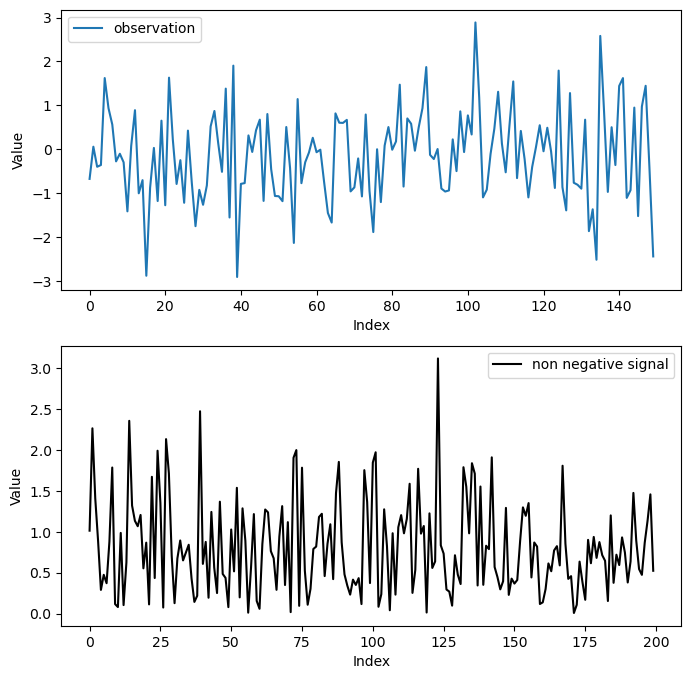

In [269]:
x_exm, s_exm =test_loader.dataset.__getitem__(5)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'non negative signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

In [270]:
def train(model, train_loader, valid_loader, num_epochs=30):
      """Train a network.
      Returns:
          loss_test {numpy} -- loss function values on test set
      """
      # Initialization
      optimizer = torch.optim.SGD(
          model.parameters(),
          lr=0.01,
        #   momentum=0.9,
        #   weight_decay=0,
      )
    #   scheduler = torch.optim.lr_scheduler.StepLR(
    #       optimizer, step_size=50, gamma=0.1
    #   )
      loss_train = np.zeros((num_epochs,))
      loss_test = np.zeros((num_epochs,)) 
      # Main loop
      for epoch in range(num_epochs):
          model.train()
          train_loss = 0
          for step, (b_x, b_s) in enumerate(train_loader):
            #   if torch.cuda.is_available():
            #     b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda() 
              s_hat = model(b_x)
              loss = F.mse_loss(s_hat, b_s, reduction="mean")
              optimizer.zero_grad()  
              loss.backward()  
              optimizer.step() 
              model.zero_grad()
              train_loss += loss.data.item()
          print(train_loss)
          loss_train[epoch] = train_loss / len(train_loader.dataset)       
          #scheduler.step()

          # validation
          model.eval()
          test_loss = 0
          for step, (b_x,b_s) in enumerate(valid_loader):
            #   if torch.cuda.is_available():
            #     b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda()
              s_hat = model(b_x)
              test_loss += F.mse_loss(s_hat, b_s, reduction="mean").data.item()
          loss_test[epoch] = test_loss / len(valid_loader.dataset)
          # Print
          if epoch % 10 == 0:
              print(
                  "     Epoch %d, Train loss %.8f, Validation loss %.8f"
                  % (epoch, loss_train[epoch], loss_test[epoch])
              )


      return loss_test

In [271]:
class PGM_Model(nn.Module):
    def __init__(self, x_size, s_size, T=6):
        super(PGM_Model, self).__init__()
        self.x_size, self.s_size = x_size, s_size
        self.H = H
        self.T = T  # ISTA Iterations
        self.A = nn.Linear(x_size, s_size, bias=False)  # Weight Matrix
        self.B = nn.Linear(s_size, s_size, bias=False)  # Weight Matrix
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1), requires_grad=True)


    def forward(self, x):
        s = F.relu(self.mu[0, :, :] * self.A(x))
        for i in range(1, self.T + 1):           
            s = F.relu(
                s - self.mu[i, :, :] * (self.B(s) + self.A(x))
            )
        return s


In [272]:
def unfolded_pgm_apply(train_loader, test_loader, T):
    x_size = 150
    s_size = 200
    pgm = PGM_Model(x_size=x_size, s_size=s_size, T=T)
    # if torch.cuda.is_available():
    #     pgm.cuda()
 
    loss_test = train(pgm, train_loader, test_loader)
    err_pgm = loss_test[-1]
    return err_pgm

In [273]:
# Number of unfoldings
tstart, tend, tstep = 0, 13, 2
T_opt = range(tstart, tend, tstep)

unfolded_pgm_MSE = []
for i in range(len(T_opt)):
    print(f'Iteration : {i}')
    T = T_opt[i]
    unfolded_pgm_MSE.append(unfolded_pgm_apply(train_loader, test_loader, T))
    
# plot the resutls  
# fig = plt.figure()
# plt.plot(T_opt, ista_MSE, label='ISTA', color='b',linewidth=0.5)
# plt.plot(T_opt, lista_MSE, label='LISTA', color='r', linewidth=2) 
# plt.xlabel('Number of iterations', fontsize=10)
# plt.ylabel('MSE', fontsize=10)
# plt.yscale("log")
# plt.legend()
# plt.show()

Iteration : 0
20.53956224926879
     Epoch 0, Train loss 0.02567445, Validation loss 0.02851975
20.002901807589595
19.474621664583125
18.965670475625394
18.484281871788372
18.0312085622636
17.608343213333836
17.213288555060526
16.84274418926304
16.49836885420174
16.1770069690648
     Epoch 10, Train loss 0.02022126, Validation loss 0.02271089
15.877588015165335
15.596754250273882
15.333912520049987
15.0880430358105
14.85517238482399
14.63483804181308
14.424871142951314
14.223555021701973
14.032505628720376
13.851939993715563
     Epoch 20, Train loss 0.01731492, Validation loss 0.01948574
13.681142016428135
13.520529299705133
13.36920025394285
13.226552726600321
13.09275412228179
12.967084992782087
12.849656822560307
12.739636115500138
12.6372210354403
Iteration : 1
22.44269516662819
     Epoch 0, Train loss 0.02805337, Validation loss 0.02916625
20.05478297987746
19.28916671227343
18.705635313640602
18.14133402068205
17.56098647971895
16.967424294523163
16.367184428324517
15.762462755